In [1]:
import uproot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
import helpfunction as helper
from __future__ import division

import collections
import NuCC_function as NuCC

Welcome to JupyROOT 6.10/08


In [2]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


# CRTinBNB tagger, Overlay or MC

In [3]:
# Load input files

inputdir = '/home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/'
outputdir = inputdir+'NumuCC_cut_analysis_V/' 
outputdir_png, outputdir_root = NuCC.prepareOutput(outputdir)

filename_overlay = 'NuCCana_overlay_V.root'
filename_data = 'NuCCana_data_V.root'
filename_ext = 'NuCCana_ext_V.root'
filename_dirt = 'NuCCana_dirt_V.root'
    
tree_name = 'numuCCAna'

In [4]:
#Open all the trees of the four files (data, ext, dirt, overlay)

data, ext, dirt, overlay = NuCC.openTrees(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
NuCC.printNumberOfEntries(data,ext,dirt,overlay)

pot_overlay = NuCC.getPOT(inputdir,filename_overlay,tree_name)
pot_dirt =  NuCC.getPOT(inputdir,filename_dirt,tree_name)

pot_data =      8.039e+18 # tor860_wcut
data_trigger = 1942081.0 #4743794 # 1987072.0 # E1DCNT_wcut
ext_trigger =  22622263.0  #2120135 #5685315 # EXT
'''
pot_data =     1.25795274297e+18# tor860_wcut
data_trigger = 1359818.0*0.4 # E1DCNT
ext_trigger =  1359818.0  #2120135 #5685315 # EXT
pot_overlay = 1.25795274297e+18/0.5
pot_dirt = 1.25795274297e18/0.04
'''
print 'POT: '
print 'Data:\t\t', pot_data
print 'Ext:\t\t', 0
print 'Overlay:\t', pot_overlay
print 'Dirt:\t\t', pot_dirt
print ''
sample = [data,ext,overlay,dirt]
scale = {data:1.0,ext:1.0,overlay:1.0,dirt:1.0}
name = {data:'data',ext:'ext',overlay:'overlay',dirt:'dirt'}

scale[data], scale[ext], scale[dirt], scale[overlay] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)

print 'Scalefactors: '
print 'Data:\t\t', scale[data]
print 'Ext:\t\t', scale[ext]
print 'Overlay:\t', scale[overlay]
print 'Dirt:\t\t', scale[dirt]


Overlay: Number of Entries:	966222
Data: Number of Entries:	34835
Ext: Number of Entries:		263935
Dirt: Number of Entries:	96465

POT: 
Data:		8.039e+18
Ext:		0
Overlay:	1.21058333557e+21
Dirt:		2.9866803255e+20

Scalefactors: 
Data:		1.0
Ext:		0.0858482195172
Overlay:	0.0066406002493
Dirt:		0.0269161715479


Warning in <TClass::Init>: no dictionary for class ROOT::TIOFeatures is available


In [5]:
# Define signals

fidVol = '(Nu_Vx>(-1.55+10) && Nu_Vx<(254.8-10)) && (Nu_Vy>(-115.53+10) && Nu_Vy<(117.47-10)) &&(Nu_Vz>(-0.1+10) && Nu_Vz<(1036.9-50))'
MCfidVol = '(MCNu_Vx>(-1.55+10) && MCNu_Vx<(254.8-10)) && (MCNu_Vy>(-115.53+10) && MCNu_Vy<(117.47-10)) &&(MCNu_Vz>(-0.1+10) && MCNu_Vz<(1036.9-50))'
numu_signal = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCle_PDG==13 && MCle_purity>0.5' # numu CC signal definition
numu_nomu = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCle_PDG!=13 && MCle_purity>0.5' # not an MC muon
numu_lowpur = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCle_purity<0.5' #low purity
numu_nc = 'fidVol && MCfidVol && MCNu_CCNC==1' # nutral current
numu_ov = 'fidVol && !MCfidVol' # out of fiducial
numu_other = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG!=14' # e.g anti nu or nue
#signal = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14'
for x in sample:
    x.SetAlias('muon','(muon_candidate_key==track_key)')
    
num_fidVol = {}
for x in sample:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)
    num_fidVol[x] = x.GetEntries('fidVol && muon')*scale[x]
    
tot_num_fidVol = num_fidVol[ext]+num_fidVol[dirt]+num_fidVol[overlay]
overlay_signals = {'numu_signal','numu_nomu','numu_lowpur','numu_nc','numu_ov','numu_other'}

In [6]:
# Load the global variables for access of functions

NuCC.loadGlobal(data,ext,dirt,overlay,scale,tot_num_fidVol,overlay_signals,sample, name, outputdir_png, outputdir_root)
#NuCC.printGlobal()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [7]:
# Print initial efficiency and purity

NuCC.printEff('muon')

Rejection on each sample:
Keep of    data:	100.00%	 reject:	0.00%
Keep of     ext:	100.00%	 reject:	0.00%
Keep of overlay:	100.00%	 reject:	0.00%
Keep of    dirt:	100.00%	 reject:	0.00%

Efficiency:	100.00%
Purity:		30.02%

Amount of    data:	126.07%
Amount of     ext:	43.29%
Amount of overlay:	52.13%
Amount of    dirt:	4.58%

Signal definition=  numu_lowpur: 1.89%	(3.63%)
Signal definition=   numu_other: 0.43%	(0.83%)
Signal definition=    numu_nomu: 3.91%	(7.50%)
Signal definition=      numu_ov: 9.72%	(18.64%)
Signal definition=  numu_signal: 30.02%	(57.58%)
Signal definition=      numu_nc: 6.15%	(11.80%)


In [8]:
track_start_border_x = '(TrackStart_x <(-1.55+1) || TrackStart_x > (254.8-1))'
track_end_border_x = '(TrackEnd_x <(-1.55+1) || TrackEnd_x > (254.8-1))'
track_start_border_y = '(TrackStart_y <(-115.53+1) || TrackStart_y > (117.47-1))'
track_end_border_y = '(TrackEnd_y <(-115.53+1) || TrackEnd_y > (117.47-1))'
track_start_border_z = '(TrackStart_z <(0.1+1) || TrackStart_z > (1036.9-1))'
track_end_border_z = '(TrackEnd_z <(0.1+1) || TrackEnd_z > (1039.9-1))'

track_end_uncontained = '(' + track_end_border_x + ' || ' + track_end_border_y + ' || ' + track_end_border_z+ ')'


data.SetAlias("track_end_uncontained",track_end_uncontained)
ext.SetAlias("track_end_uncontained",track_end_uncontained)
overlay.SetAlias("track_end_uncontained",track_end_uncontained)
dirt.SetAlias("track_end_uncontained",track_end_uncontained)



True

13210
5682
4875
1069


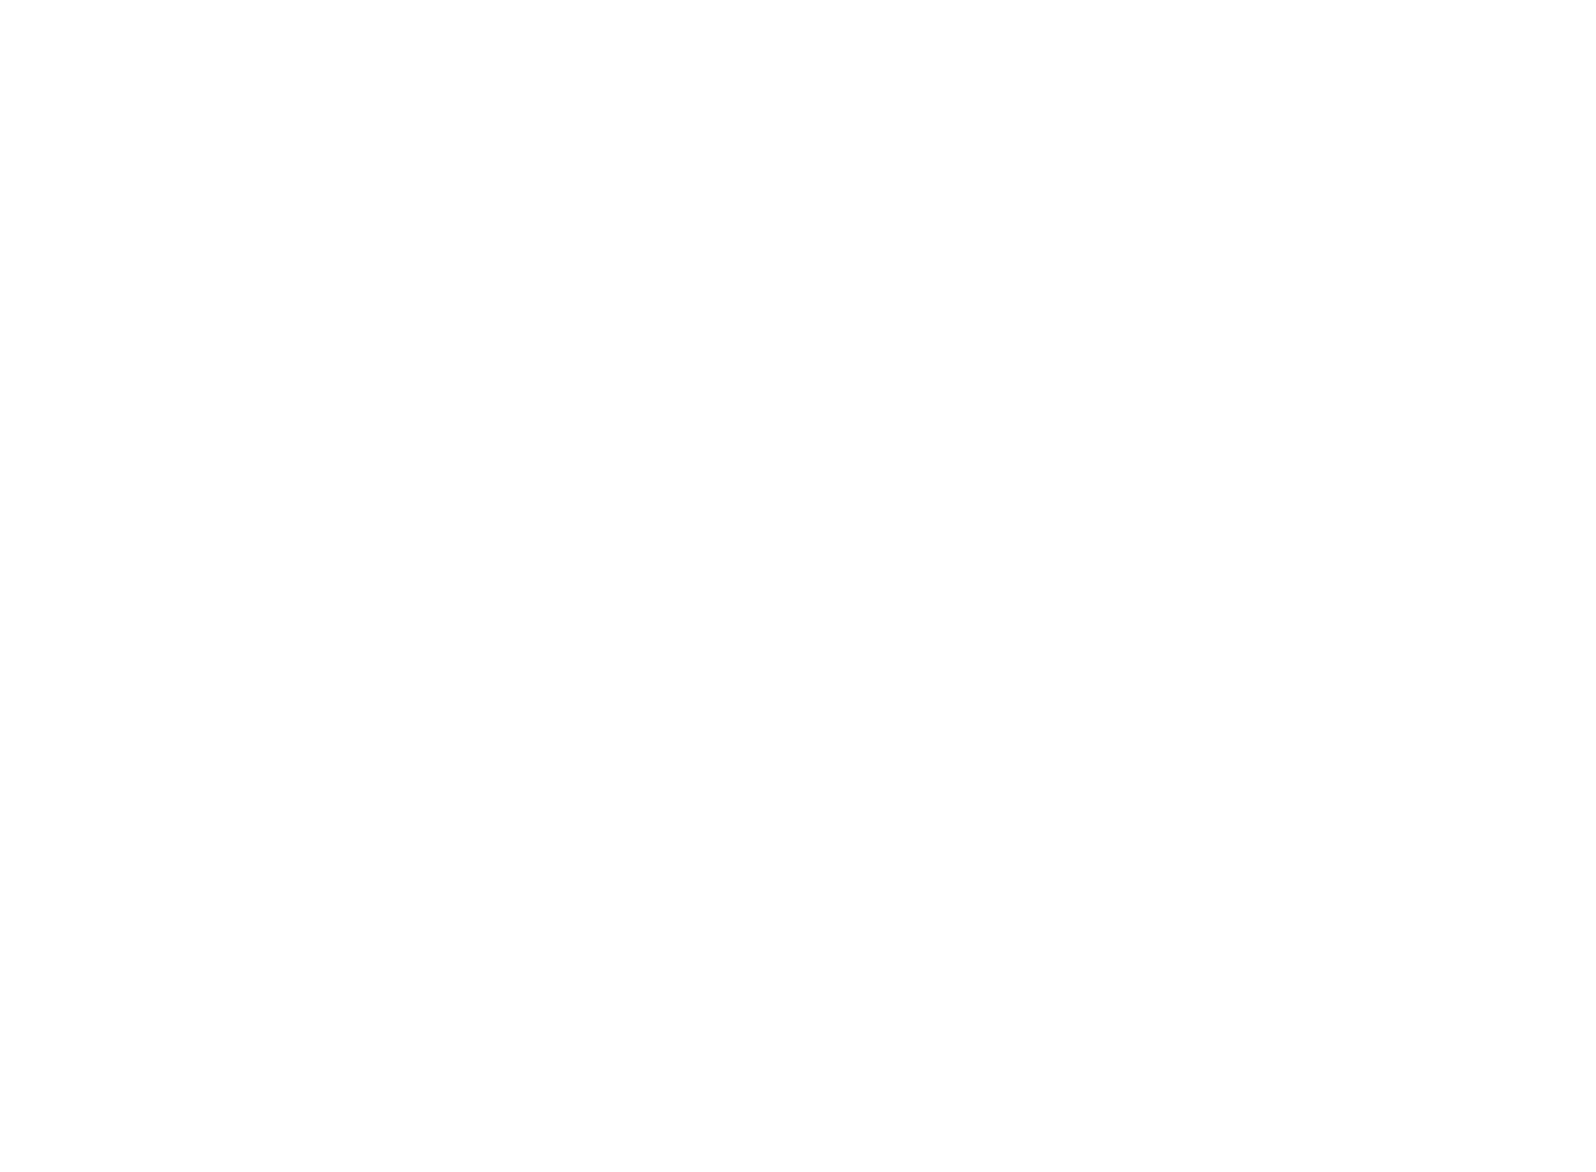

In [9]:
title = 'test'
xbins = 100
xstart = -2300
xend = 2300
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

h_1 = ROOT.TH1F("h_1",title,xbins,xstart,xend)
h_2 = ROOT.TH1F("h_2",title,xbins,xstart,xend)

##overlay.Draw('crtt0_time>>h_1','crtt0_plane!=-1 && muon && numu_signal && track_end_uncontained','')
#overlay.Draw('crtt0_time>>h_2','crtt0_plane!=-1 && muon && numu_signal && a_adc_length<32 && track_end_uncontained','')


#h_1.Draw()
#h_2.Draw('same')
print overlay.GetEntries('crtt0_plane!=-1 && muon && numu_signal')
print overlay.GetEntries('crtt0_plane!=-1 && muon && numu_signal && a_adc_length==32')

print overlay.GetEntries('crtt0_plane!=-1 && muon && numu_signal && track_end_uncontained')
print overlay.GetEntries('crtt0_plane!=-1 && muon && numu_signal && a_adc_length==32 && track_end_uncontained')
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V//png/FlashTime_corr.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V//root/FlashTime_corr.root has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_ext_func (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_dirt_func (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_lowpur (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_other (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_nomu (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_ov (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_signal (Potential memory leak).
Warning in <T

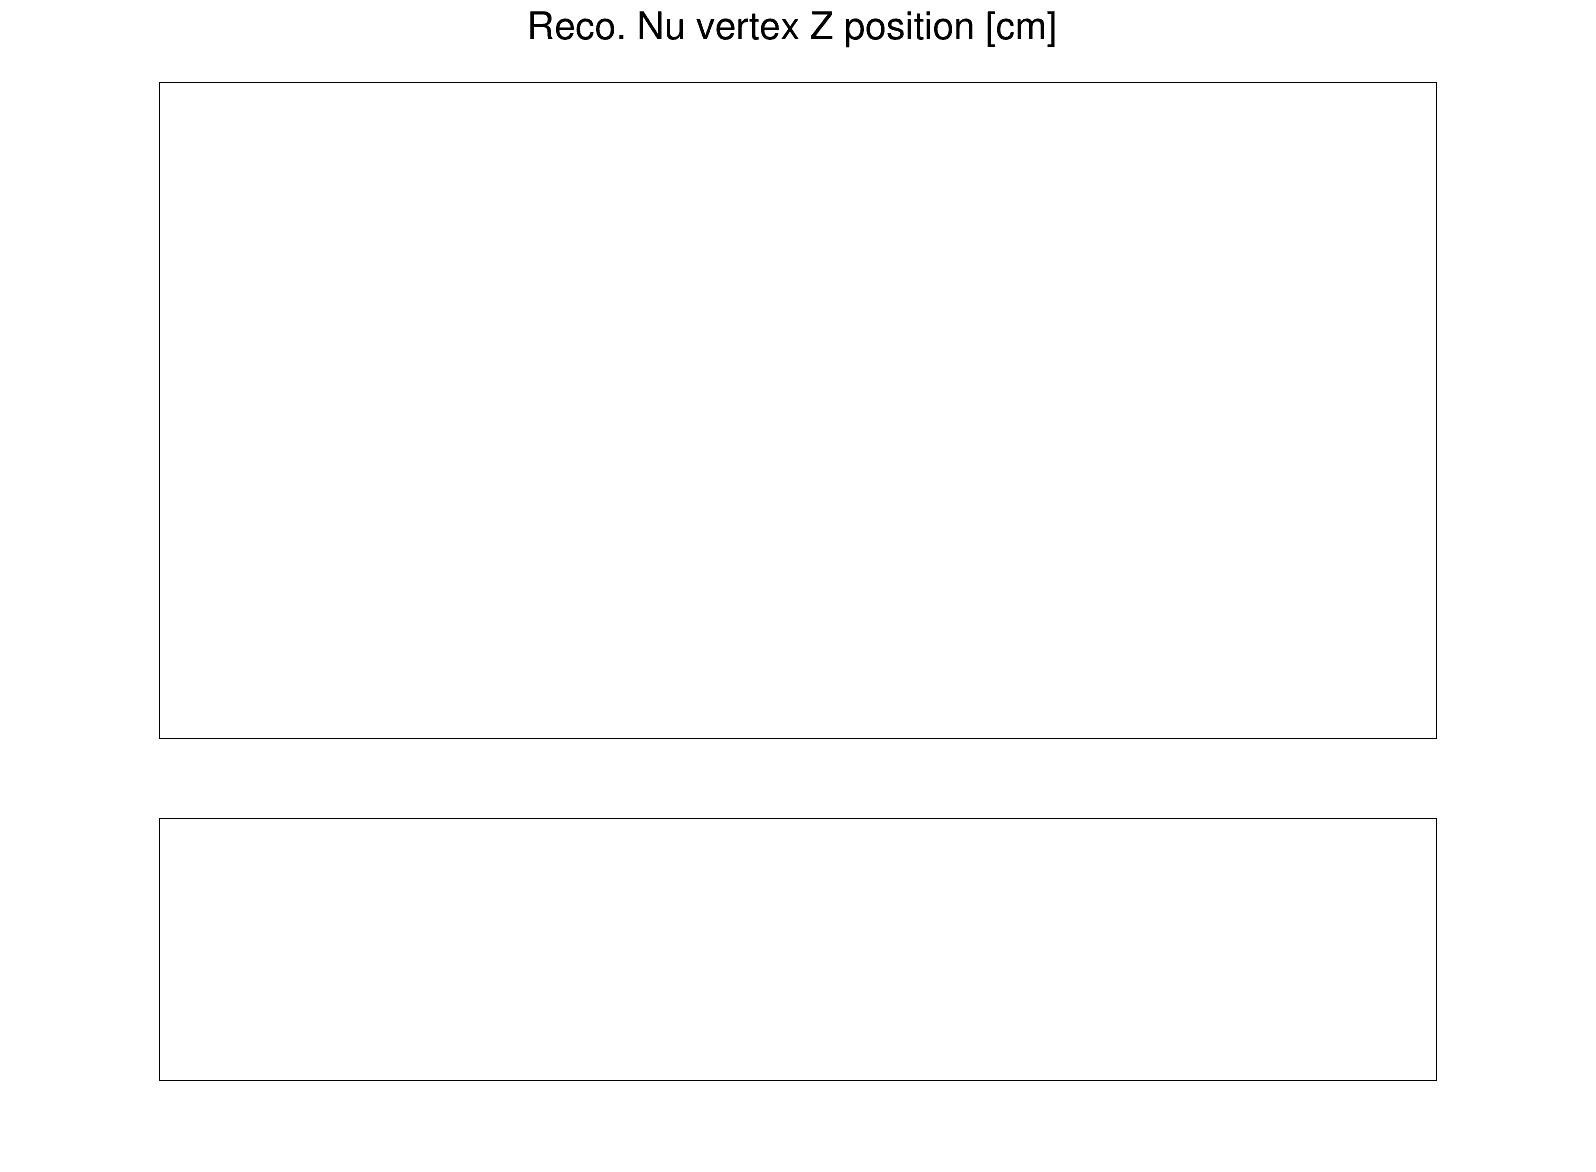

In [10]:
# Generate stacked plots without any cuts

#NuCC.make_stacked_histo_plot('fidVol','TimFla','Flash_time [us]',2,6,20,'FlashTime')

NuCC.make_stacked_histo_plot_flashcorr('fidVol','TimFla','Flash_time [us]',2.3,5.9,20,'FlashTime_corr')
NuCC.make_stacked_histo_plot_crtcorr('fidVol','crthit_ts0','CRT hit time [us]',2.3,5.9,20,'CRTTime_corr')

NuCC.make_stacked_histo_plot('fidVol && muon','TrackMomMCS_mom','Track momentum [GeV]',0,3,20,'MCSMom')
NuCC.make_stacked_histo_plot('fidVol && muon','TrackLength','Track length [cm]',0,500,20,'tracklength')
NuCC.make_stacked_histo_plot('fidVol && TrackTheta!=-9 && muon','cos(TrackTheta)','cos(theta)',-1,1,20,'costheta')
NuCC.make_stacked_histo_plot('fidVol && TrackTheta!=-9 && muon','TrackPhi','Phi on muoncandidate',-3.1416,3.1416,20,'trackphi')
NuCC.make_stacked_histo_plot('fidVol && muon','NuScore','Total NuScore of event',0,1,20,'NuScore')
NuCC.make_stacked_histo_plot('fidVol && muon','NuTracks','Number of tracks',0,8,8,'num_tracks')

NuCC.make_stacked_histo_plot('fidVol && muon','Nu_Vx','Reco. Nu vertex X position [cm]',0,250,50,'NuVx')
NuCC.make_stacked_histo_plot('fidVol && muon','Nu_Vy','Reconstructed neutrino vertex Y position [cm]',-110,115,50,'NuVy')
NuCC.make_stacked_histo_plot('fidVol && muon','Nu_Vz','Reco. Nu vertex Z position [cm]',-20,1020,50,'NuVz')


Warning in <TROOT::Append>: Replacing existing TH1: h_ext_func (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_dirt_func (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_lowpur (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_other (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_nomu (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_ov (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_signal (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_nc (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V//png/CRTT0_corr_big.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00

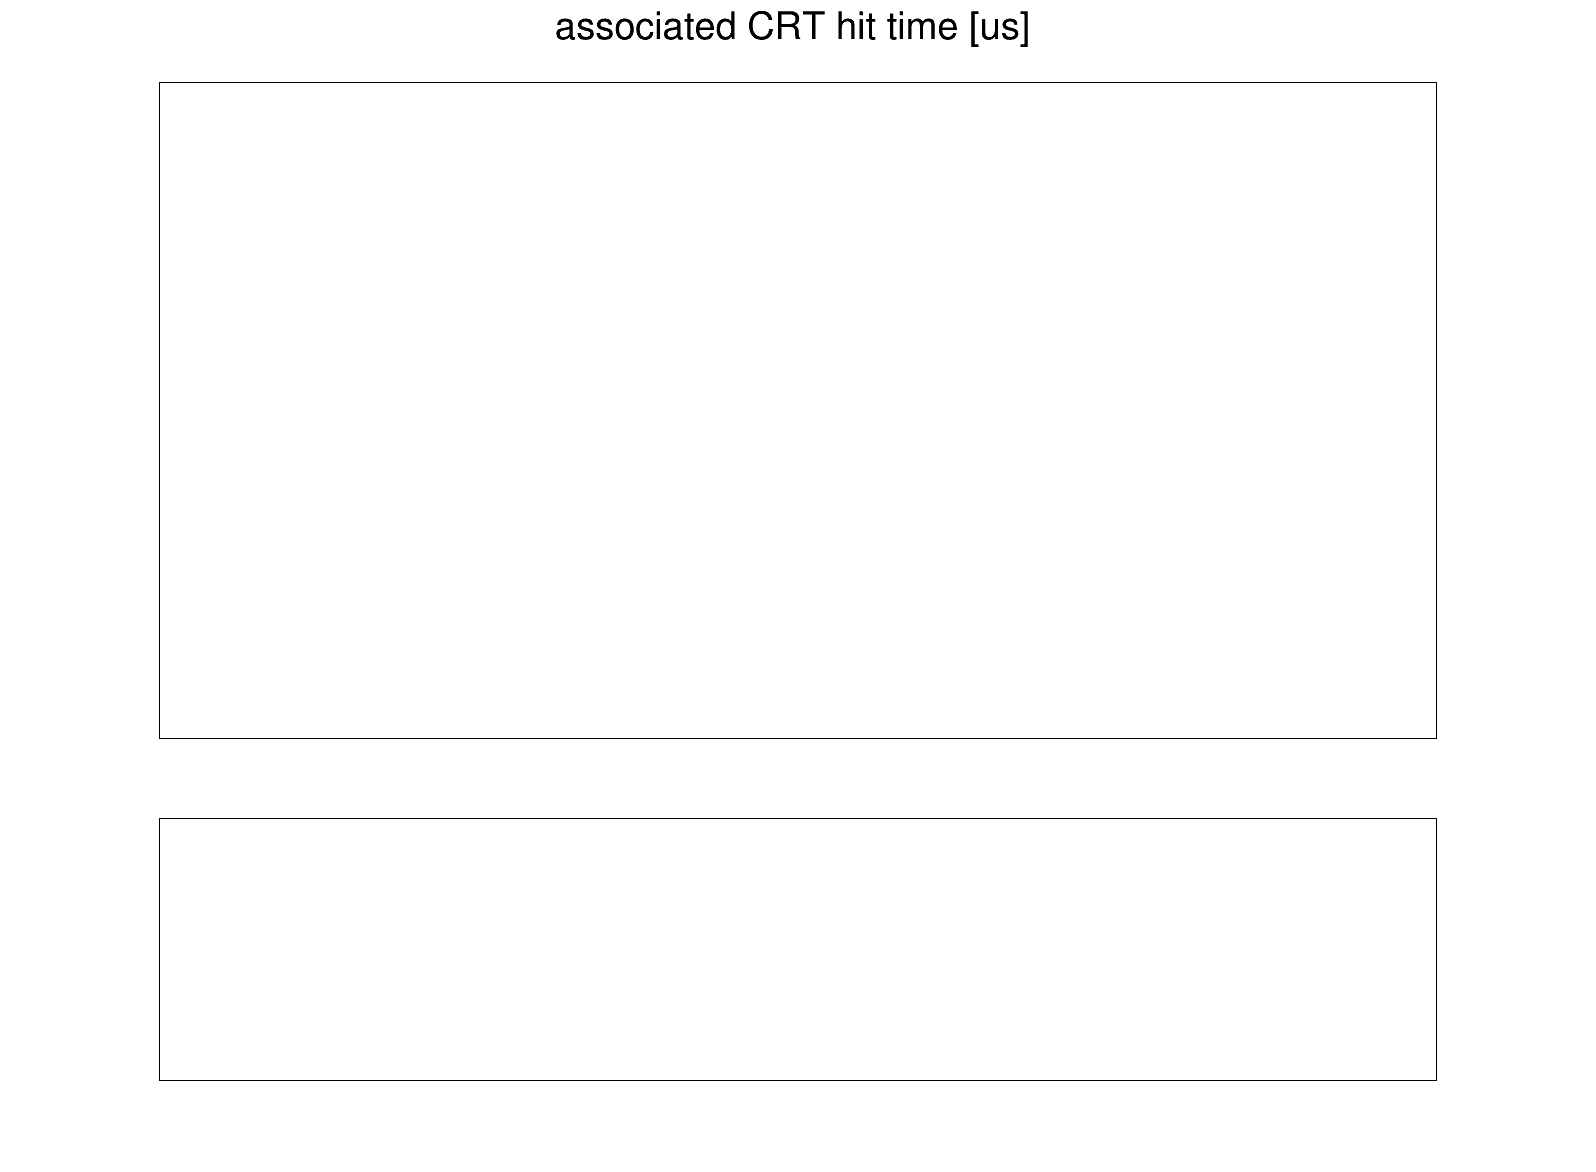

In [11]:
#NuCC.make_stacked_histo_plot_crtt0corr('fidVol','crtt0_time','associated CRT hit time [us]',2.3,5.9,20,'CRTT0_corr_all')
NuCC.make_stacked_histo_plot_crtt0corr('fidVol && muon','crtt0_time','associated CRT hit time [us]',-2000,2000,20,'CRTT0_corr_big')

In [12]:
# Define CRT cut

data.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-4)<1 || crtt0_time==-1)")
ext.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-3.57+3.195-4)<1 || crtt0_time==-1)")
overlay.SetAlias("crt_cut","(abs(crtt0_time-4)<1 || crtt0_time==-1)")
dirt.SetAlias("crt_cut","(abs(crtt0_time-4)<1 || crtt0_time==-1)")

track_start_border_x = '(TrackStart_x <(-1.55+5) || TrackStart_x > (254.8-5))'
track_end_border_x = '(TrackEnd_x <(-1.55+5) || TrackEnd_x > (254.8-5))'
track_start_border_y = '(TrackStart_y <(-115.53+5) || TrackStart_y > (117.47-5))'
track_end_border_y = '(TrackEnd_y <(-115.53+5) || TrackEnd_y > (117.47-5))'
track_start_border_z = '(TrackStart_z <(0.1+5) || TrackStart_z > (1036.9-5))'
track_end_border_z = '(TrackEnd_z <(0.1+5) || TrackEnd_z > (1039.9-5))'

track_end_uncontained = track_end_border_x + ' || ' + track_end_border_y + ' || ' + track_end_border_z


data.SetAlias("track_end_uncontained",track_end_uncontained)
ext.SetAlias("track_end_uncontained",track_end_uncontained)
overlay.SetAlias("track_end_uncontained",track_end_uncontained)
dirt.SetAlias("track_end_uncontained",track_end_uncontained)



data.SetAlias("crt_cut_test","(crt_cut || !track_end_uncontained)")
ext.SetAlias("crt_cut_test","(crt_cut || !track_end_uncontained)")
overlay.SetAlias("crt_cut_test","(crt_cut || !track_end_uncontained)")
dirt.SetAlias("crt_cut_test","(crt_cut || !track_end_uncontained)")

True

Warning in <TROOT::Append>: Replacing existing TH1: h_ext_func (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_dirt_func (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_lowpur (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_other (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_nomu (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_ov (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_signal (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_nc (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V//png/CRTT0_corr_test.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v08_0

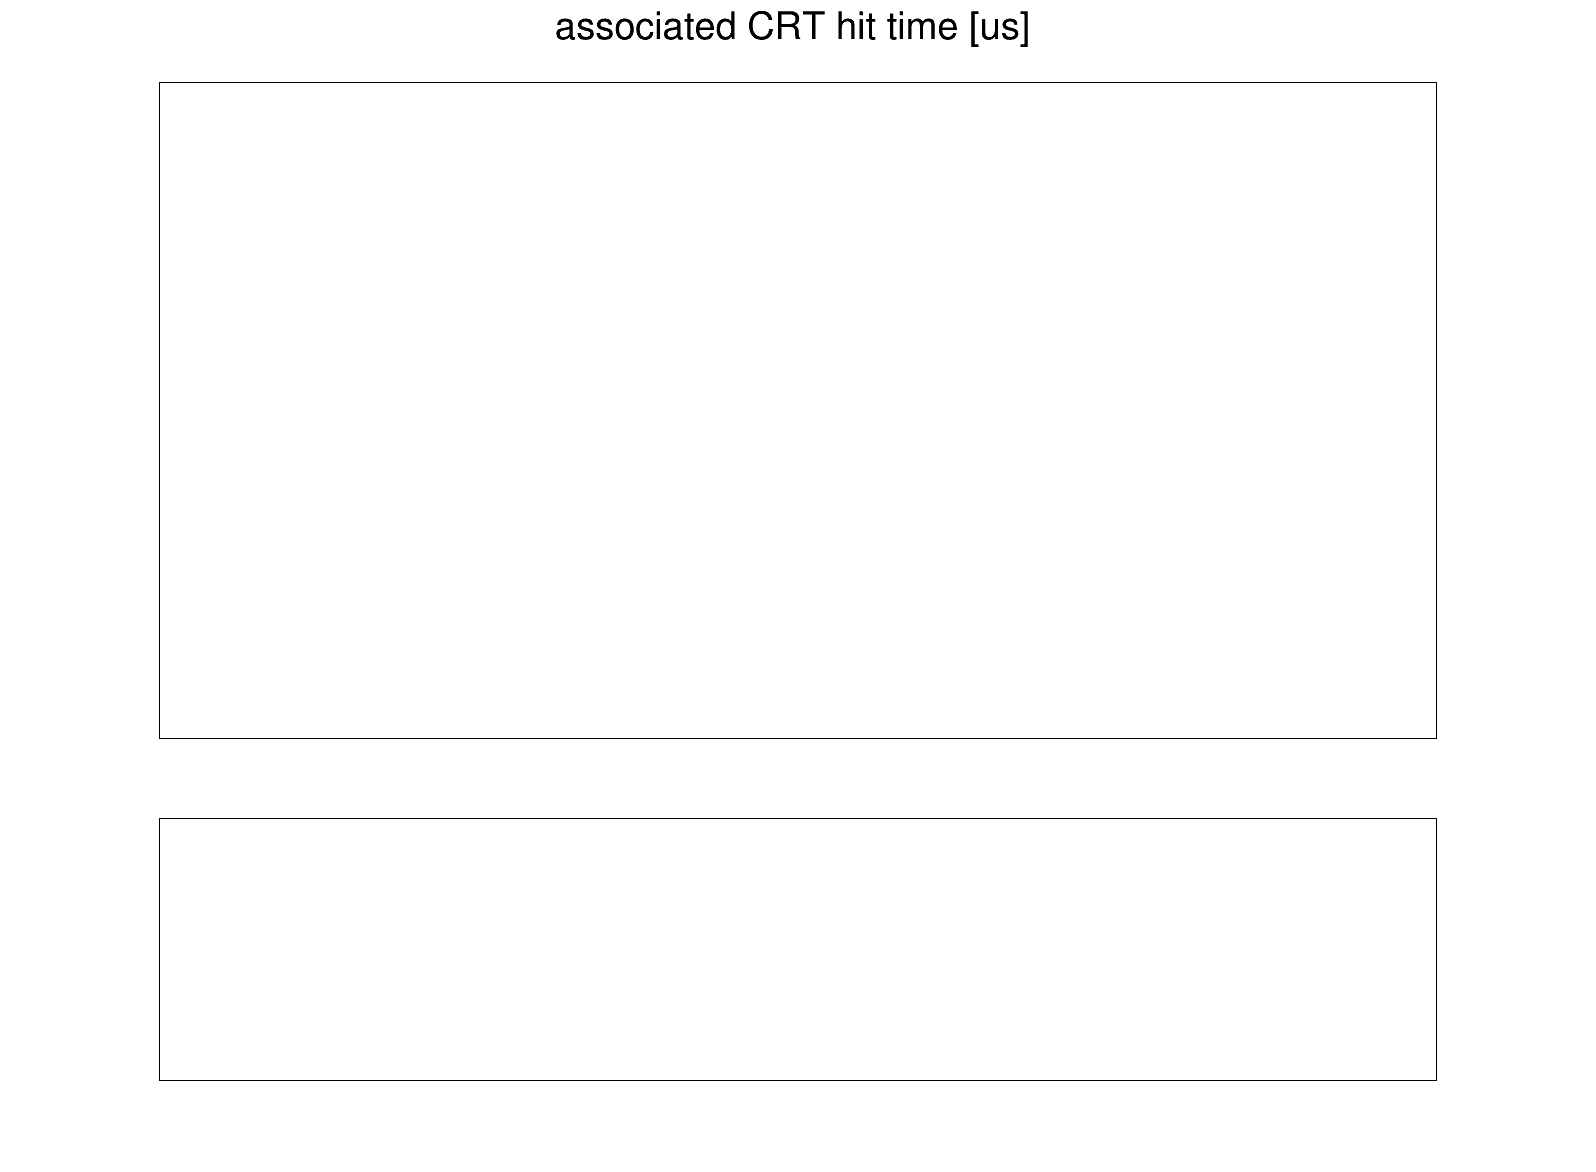

In [13]:
NuCC.make_stacked_histo_plot_crtt0corr('fidVol && (crt_cut || NuTracks != 1)','crtt0_time','associated CRT hit time [us]',-2000,2000,20,'CRTT0_corr_test')

In [14]:
# Print efficiency with crt cut

NuCC.printEff('crt_cut && muon')

#NuCC.printEff('crt_cut_test && muon')

Rejection on each sample:
Keep of    data:	87.37%	 reject:	12.63%
Keep of     ext:	79.99%	 reject:	20.01%
Keep of overlay:	92.63%	 reject:	7.37%
Keep of    dirt:	84.71%	 reject:	15.29%

Efficiency:	96.46%
Purity:		33.36%

Amount of    data:	126.90%
Amount of     ext:	39.90%
Amount of overlay:	55.63%
Amount of    dirt:	4.47%

Signal definition=  numu_lowpur: 1.44%	(2.60%)
Signal definition=   numu_other: 0.47%	(0.85%)
Signal definition=    numu_nomu: 4.35%	(7.83%)
Signal definition=      numu_ov: 9.43%	(16.96%)
Signal definition=  numu_signal: 33.36%	(59.96%)
Signal definition=      numu_nc: 6.56%	(11.79%)


In [15]:
#NuCC.printEff('crt_cut')

Warning in <TROOT::Append>: Replacing existing TH1: h_ext_func (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_dirt_func (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_lowpur (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_other (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_nomu (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_ov (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_signal (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_nc (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V//png/FlashTime_corr_crt.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/mcc9.1/v0

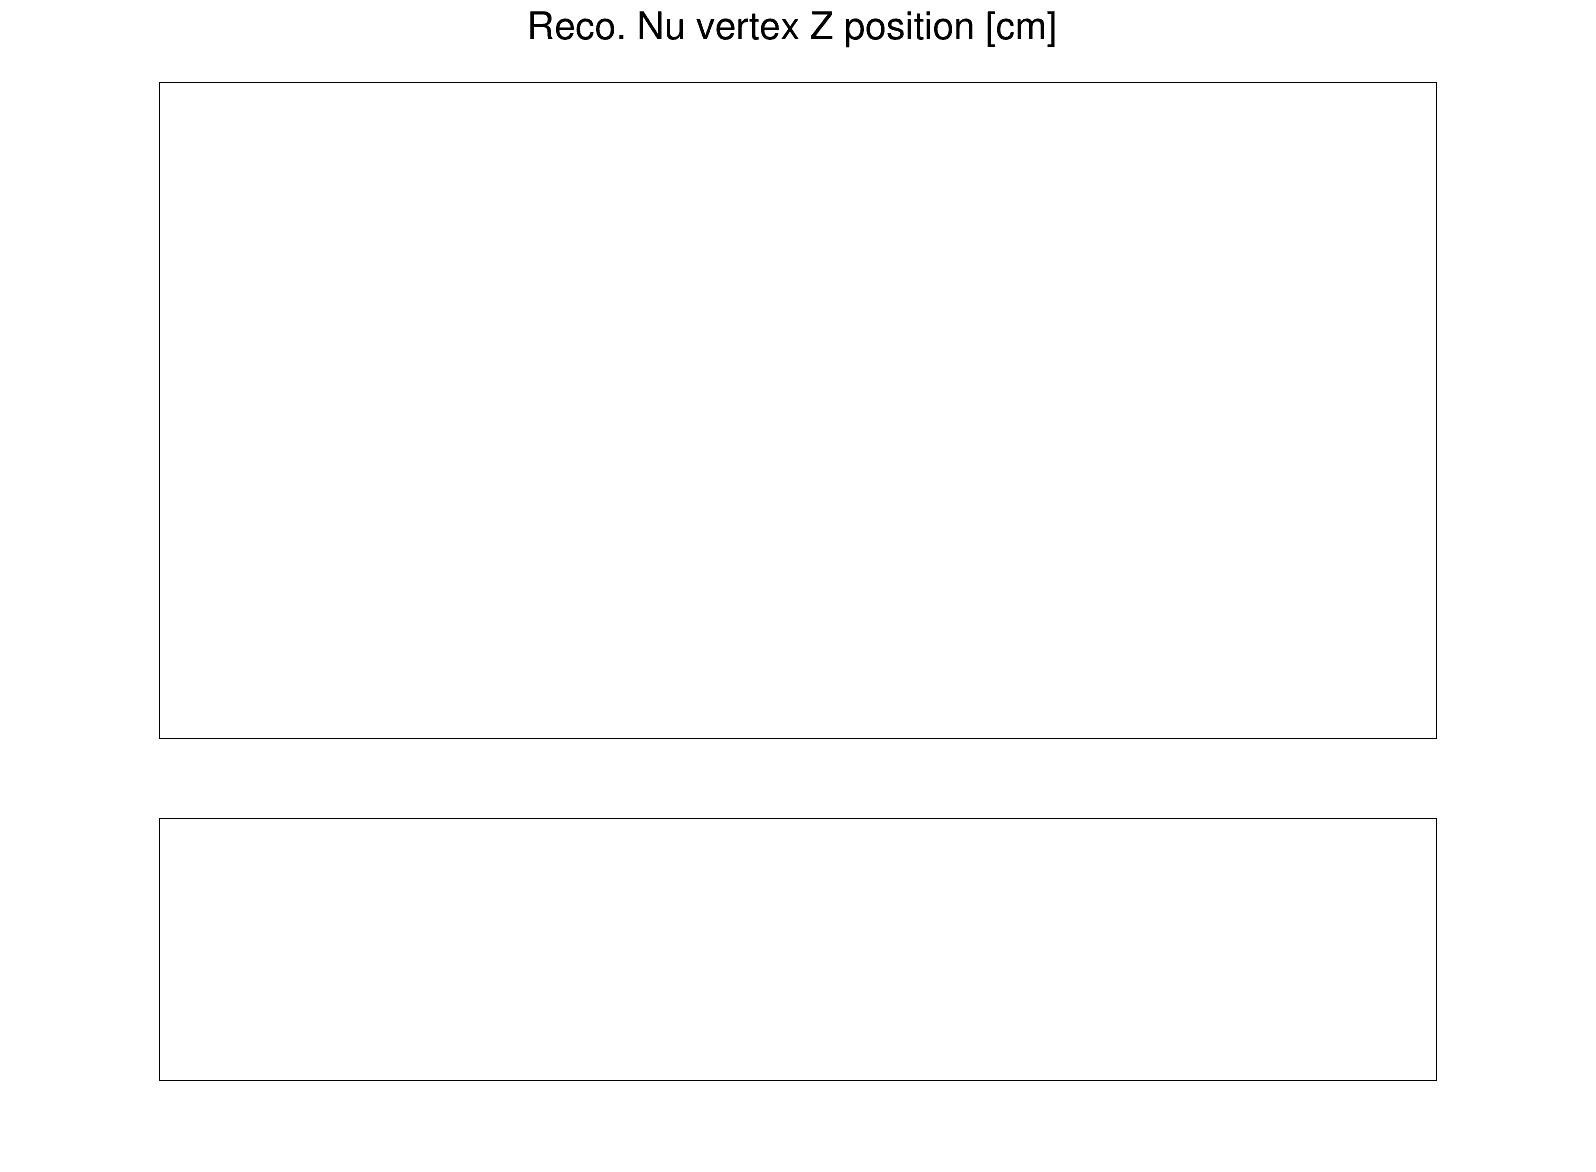

In [16]:
# generate stacked plots with crt cut
cut = 'fidVol && muon && crt_cut'
name = '_crt'

NuCC.make_stacked_histo_plot_flashcorr(cut,'TimFla','Flash_time [us]',2.3,5.9,20,'FlashTime_corr'+name)
NuCC.make_stacked_histo_plot_crtcorr(cut,'crthit_ts0','CRT hit time [us]',2.3,5.9,20,'CRTTime_corr'+name)

NuCC.make_stacked_histo_plot(cut,'TrackMomMCS_mom','Track momentum [GeV]',0,3,20,'MCSMom'+name)
NuCC.make_stacked_histo_plot(cut,'TrackLength','Track length [cm]',0,500,20,'tracklength'+name)
NuCC.make_stacked_histo_plot(cut + ' && TrackTheta!=-9','cos(TrackTheta)','cos(theta)',-1,1,20,'costheta'+name)
NuCC.make_stacked_histo_plot(cut + ' && TrackTheta!=-9','TrackPhi','Phi on muoncandidate',-3.1416,3.1416,20,'trackphi'+name)
NuCC.make_stacked_histo_plot(cut,'NuScore','Total NuScore of event',0,1,20,'NuScore'+name)
NuCC.make_stacked_histo_plot(cut,'NuTracks','Number of tracks',0,8,8,'num_track'+name)

NuCC.make_stacked_histo_plot(cut,'Nu_Vx','Reco. Nu vertex X position [cm]',0,250,50,'NuVx'+name)
NuCC.make_stacked_histo_plot(cut,'Nu_Vy','Reconstructed neutrino vertex Y position [cm]',-110,115,50,'NuVy'+name)
NuCC.make_stacked_histo_plot(cut,'Nu_Vz','Reco. Nu vertex Z position [cm]',-20,1020,50,'NuVz'+name)

In [17]:
# Define track length cut

data.SetAlias("tracklength_cut","TrackLength>29")
ext.SetAlias("tracklength_cut","TrackLength>29")
overlay.SetAlias("tracklength_cut","TrackLength>29")
dirt.SetAlias("tracklength_cut","TrackLength>29")

True

In [18]:
# Efficiency and purity with crt and tracklength cut

NuCC.printEff('muon && crt_cut && tracklength_cut')

Rejection on each sample:
Keep of    data:	72.90%	 reject:	27.10%
Keep of     ext:	65.26%	 reject:	34.74%
Keep of overlay:	77.91%	 reject:	22.09%
Keep of    dirt:	59.37%	 reject:	40.63%

Efficiency:	92.75%
Purity:		38.89%

Amount of    data:	128.39%
Amount of     ext:	39.47%
Amount of overlay:	56.73%
Amount of    dirt:	3.80%

Signal definition=  numu_lowpur: 1.48%	(2.61%)
Signal definition=   numu_other: 0.44%	(0.77%)
Signal definition=    numu_nomu: 4.08%	(7.19%)
Signal definition=      numu_ov: 8.07%	(14.23%)
Signal definition=  numu_signal: 38.89%	(68.56%)
Signal definition=      numu_nc: 3.76%	(6.63%)


Warning in <TROOT::Append>: Replacing existing TH1: h_ext_func (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_dirt_func (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_lowpur (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_other (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_nomu (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_ov (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_signal (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_nc (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V//png/FlashTime_corr_crt_tracklen.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/ub_data/

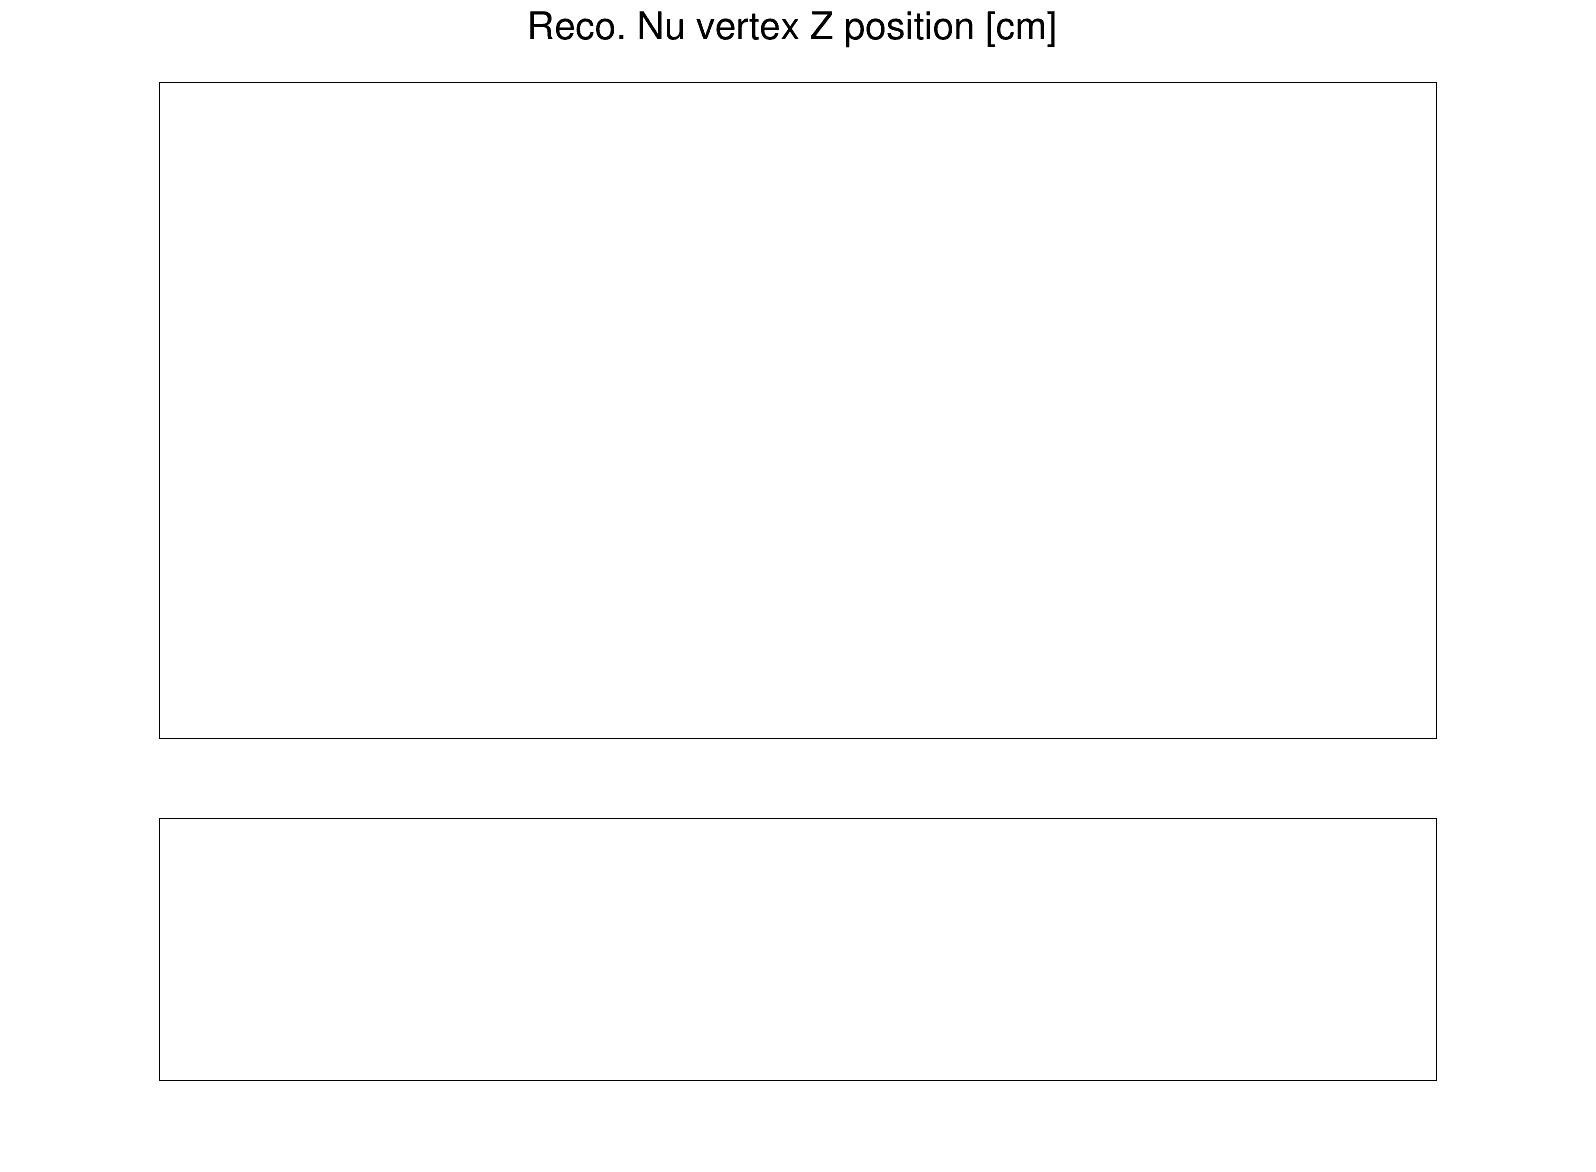

In [19]:
# Generate stacked histograms with crt cut and tracklength cut
cut = 'fidVol && muon && crt_cut && tracklength_cut'
name = '_crt_tracklen'

NuCC.make_stacked_histo_plot_flashcorr(cut,'TimFla','Flash_time [us]',2.3,5.9,20,'FlashTime_corr'+name)
NuCC.make_stacked_histo_plot_crtcorr(cut,'crthit_ts0','CRT hit time [us]',2.3,5.9,20,'CRTTime_corr'+name)

NuCC.make_stacked_histo_plot(cut,'TrackMomMCS_mom','Track momentum [GeV]',0,3,20,'MCSMom'+name)
NuCC.make_stacked_histo_plot(cut,'TrackLength','Track length [cm]',0,500,20,'tracklength'+name)
NuCC.make_stacked_histo_plot(cut+' && TrackTheta!=-9','cos(TrackTheta)','cos(theta)',-1,1,20,'costheta'+name)
NuCC.make_stacked_histo_plot(cut+' && TrackTheta!=-9','TrackPhi','Phi on muoncandidate',-3.1416,3.1416,20,'trackphi'+name)
NuCC.make_stacked_histo_plot(cut,'NuScore','Total NuScore of event',0,1,20,'NuScore'+name)
NuCC.make_stacked_histo_plot(cut,'NuTracks','Number of tracks',0,8,8,'num_tracks'+name)

NuCC.make_stacked_histo_plot(cut,'Nu_Vx','Reco. Nu vertex X position [cm]',0,250,50,'NuVx'+name)
NuCC.make_stacked_histo_plot(cut,'Nu_Vy','Reconstructed neutrino vertex Y position [cm]',-110,115,50,'NuVy'+name)
NuCC.make_stacked_histo_plot(cut,'Nu_Vz','Reco. Nu vertex Z position [cm]',-20,1020,50,'NuVz'+name)

In [20]:
# Define track length cut

data.SetAlias("nuscore_cut","NuScore>0.2")
ext.SetAlias("nuscore_cut","NuScore>0.2")
overlay.SetAlias("nuscore_cut","NuScore>0.2")
dirt.SetAlias("nuscore_cut","NuScore>0.2")

True

In [21]:
# Efficiency and purity with crt and tracklength cut

NuCC.printEff('muon && crt_cut && tracklength_cut && nuscore_cut')

Rejection on each sample:
Keep of    data:	37.28%	 reject:	62.72%
Keep of     ext:	9.74%	 reject:	90.26%
Keep of overlay:	58.49%	 reject:	41.51%
Keep of    dirt:	20.17%	 reject:	79.83%

Efficiency:	77.31%
Purity:		65.13%

Amount of    data:	131.93%
Amount of     ext:	11.83%
Amount of overlay:	85.57%
Amount of    dirt:	2.59%

Signal definition=  numu_lowpur: 1.07%	(1.25%)
Signal definition=   numu_other: 0.74%	(0.87%)
Signal definition=    numu_nomu: 7.42%	(8.67%)
Signal definition=      numu_ov: 6.06%	(7.08%)
Signal definition=  numu_signal: 65.13%	(76.11%)
Signal definition=      numu_nc: 5.14%	(6.01%)


Warning in <TROOT::Append>: Replacing existing TH1: h_ext_func (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_dirt_func (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_lowpur (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_other (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_nomu (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_ov (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_signal (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: numu_nc (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_17/NumuCC_cut_analysis_V//png/FlashTime_corr_crt_tracklen_nuscore.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/

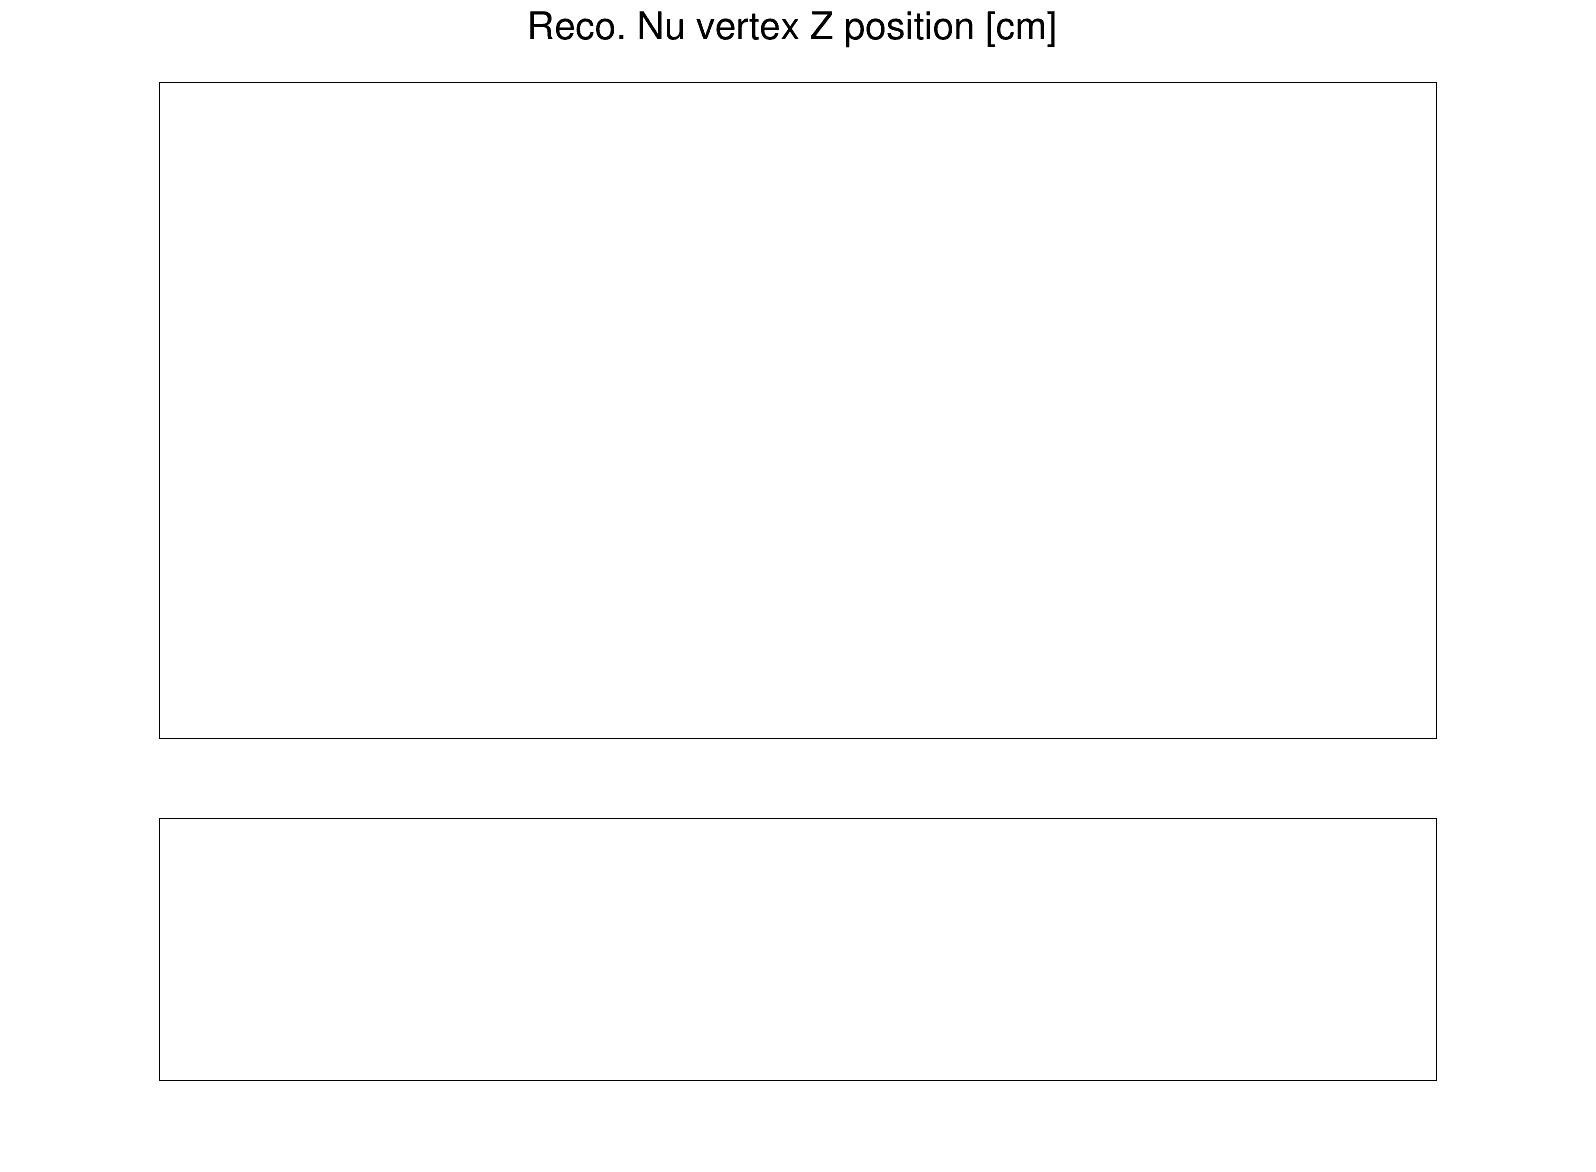

In [22]:
# Generate stacked histograms with crt cut and tracklength cut
cut = 'fidVol &&muon && crt_cut && tracklength_cut && nuscore_cut'
name = '_crt_tracklen_nuscore'

NuCC.make_stacked_histo_plot_flashcorr(cut,'TimFla','Flash_time [us]',2.3,5.9,20,'FlashTime_corr'+name)
NuCC.make_stacked_histo_plot_crtcorr(cut,'crthit_ts0','CRT hit time [us]',2.3,5.9,20,'CRTTime_corr'+name)

NuCC.make_stacked_histo_plot(cut,'TrackMomMCS_mom','Track momentum [GeV]',0,3,20,'MCSMom'+name)
NuCC.make_stacked_histo_plot(cut,'TrackLength','Track length [cm]',0,500,20,'tracklength'+name)
NuCC.make_stacked_histo_plot(cut+' && TrackTheta!=-9','cos(TrackTheta)','cos(theta)',-1,1,20,'costheta'+name)
NuCC.make_stacked_histo_plot(cut+' && TrackTheta!=-9','TrackPhi','Phi on muoncandidate',-3.1416,3.1416,20,'trackphi'+name)
NuCC.make_stacked_histo_plot(cut,'NuScore','Total NuScore of event',0,1,20,'NuScore'+name)
NuCC.make_stacked_histo_plot(cut,'NuTracks','Number of tracks',0,8,8,'num_tracks'+name)

NuCC.make_stacked_histo_plot(cut,'Nu_Vx','Reco. Nu vertex X position [cm]',0,250,50,'NuVx'+name)
NuCC.make_stacked_histo_plot(cut,'Nu_Vy','Reconstructed neutrino vertex Y position [cm]',-110,115,50,'NuVy'+name)
NuCC.make_stacked_histo_plot(cut,'Nu_Vz','Reco. Nu vertex Z position [cm]',-20,1020,50,'NuVz'+name)